In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train import *


def restore(
    dataset='../input/jigsaw-translated-distilled-ds4/jigsaw_mltc_ds973669s4_ml.npz',
    model_id='jplu/tf-xlm-roberta-large',
tpu_id=                                                      't8e',
path     =                      'jigsaw/t04/20200427_205530_t8b',
gcs       =                                             'hm-eu-w4',
optimizer  =                                                'AdamW',
loss_fn        =                                           'bce',
max_len        =                                             192,
seed            =                                             0,
batch_size       =                                            28,
epochs                   =                                    26,
dropout            =                                              0.3,
lr                  =                                     5.56954e-05,
weight_decay         =                                    7.24646e-07,
label_smoothing       =                                      0.027509,
pos_weight             =                                      1.29453,
gamma                   =                                     1.70358,
warm_up                  =                                    1.77756):
    
    """ build and train a TFAutoModel from npz or tfrec dataset """
    params = dict(locals())
#     params.update(kwargs)
    params = pd.DataFrame(params, index=[0])
    if params.loc[0, 'loss_fn'] != 'focal':
        del params['gamma']
        del params['pos_weight']
    kw_params = params.T[0].to_dict()
    print(params.T)
    gc.collect()

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    strategy = setup_tpu(tpu_id)

    ## Configuration
#     path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
    gcs_path = f'gs://{gcs}/{path}'
    checkpoint_path = f"{gcs_path}/best_model.tf"
    print('gcs_path:', gcs_path)
    params['gcs_path'] = gcs_path

    ## Load and Train
    with strategy.scope():
        model = build_model(**kw_params)
#     model, preds, sub = train_model(model, strategy, checkpoint_path, **kw_params)

#     ## Save results
#     plot_history(model.history, path, gcs)
#     history = pd.DataFrame(model.history.history)
#     print(history)
#     history.to_csv(f'{gcs_path}/history.csv', index=False)

    # load best
    # latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint_path = f'{gcs_path}/best_model.tf'
    with strategy.scope():
        model.load_weights(checkpoint_path)

    batch_size = batch_size * strategy.num_replicas_in_sync
    print('batch_size:', batch_size)
    
    valid_dataset, test_dataset = val_np_dataset(batch_size=batch_size)
    preds = model.predict(valid_dataset, verbose=1)
    sub_y = model.predict(test_dataset, verbose=1)

    ## Load Dataset
    comp_ds = '../input/jigsaw-multilingual-toxic-comment-classification'
    valid = pd.read_csv(f'{comp_ds}/validation.csv')
#     test = pd.read_csv(f'{comp_ds}/test.csv')
    sub = pd.read_csv(f'{comp_ds}/sample_submission.csv')

    valid['pred'] = preds
    valid.to_csv(f'{gcs_path}/valid_oof.csv', index=False)

    valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
    plt.legend([0, 1])
    save_fig('valid_hist.png', path, gcs)

    valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
    plt.legend(valid.lang.unique())
    save_fig('valid_toxic_hist.png', path, gcs)

    valid_auc = roc_auc_score(valid.toxic, valid.pred)
    print('AUC:', valid_auc,
          'toxic:', valid.toxic.mean(),
          'pred:', valid.pred.mean(),
          'ratio:', (valid.pred > 0.5).mean())

    ## Submission
    sub['toxic'] = sub_y
    sub.to_csv(f'{gcs_path}/submission.csv', index=False)

    sub.toxic.hist(bins=100, log=True)
    save_fig('sub_hist.png', path, gcs)
    print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())
#     assert sub.toxic.mean() < 0.3

    ## Save params
    params['auc'] = valid_auc
    params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
    print(params.T)

    return valid_auc

restore()

                                                                 0
warm_up                                                    1.77756
label_smoothing                                           0.027509
weight_decay                                           7.24646e-07
lr                                                     5.56954e-05
dropout                                                        0.3
epochs                                                          26
batch_size                                                      28
seed                                                             0
max_len                                                        192
loss_fn                                                        bce
optimizer                                                    AdamW
gcs                                                       hm-eu-w4
path                                jigsaw/t04/20200427_205530_t8b
tpu_id                                                        

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8
gcs_path: gs://hm-eu-w4/jigsaw/t04/20200427_205530_t8b
batch_size: 224
(8000, 192) (63812, 192) (8000,)
285/285 [==============================] - 79s 276ms/step
AUC: 0.9597905633413794 toxic: 0.15375 pred: 0.1787984 ratio: 0.148125
mean: 0.23654445 ratio: 0.2063091581520717
                                                                 0
warm_up                                                    1.77756
label_smoothing                                           0.027509
weight_decay                                           7.24646e-07
lr                                                     5.56954e-05
dropout                                                        0.3
epochs                                                          26
batch_size                                                      28
seed                                                             0
max_len                                                        192
loss_fn                                  

0.9597905633413794

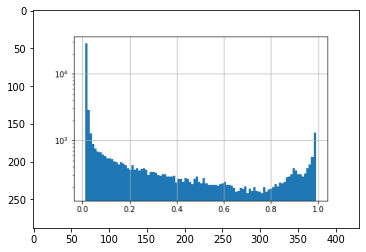

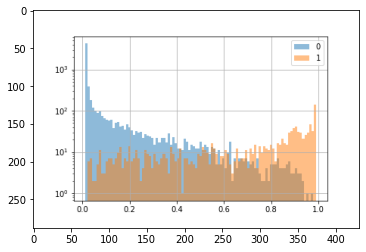

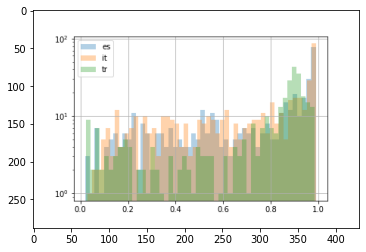

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('sub_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)

In [4]:
# import pdb; pdb.pm()